In [1]:
#installing dependencies
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaitanyabvs","key":"f4145b5fd94e48c0767a83abd072d774"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#changing permissin
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 321M/330M [00:13<00:00, 23.0MB/s]
100% 330M/330M [00:13<00:00, 26.0MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'face-mask-12k-images-dataset.zip'

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('done')

done


# **Model Training**

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Lambda, Input
from keras.models import Sequential,Model
from keras.callbacks import ModelCheckpoint
import numpy as np

In [7]:
IMG_SIZE = 224

train_path = '/content/Face Mask Dataset/Train'
val_path = '/content/Face Mask Dataset/Validation'
test_path = '/content/Face Mask Dataset/Test'

In [8]:
vgg = VGG16(input_shape = [IMG_SIZE,IMG_SIZE,3], weights = 'imagenet', include_top = False )

58892288/58889256 [==============================] - 2s 0us/step


In [9]:
for layer in vgg.layers:
    layer.trainable = False

In [10]:
num_classes = 2

X = Flatten()(vgg.output)
prediction = Dense(2, activation = 'softmax')(X)

In [11]:
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
train_datagen = ImageDataGenerator(1./255)
train_set = train_datagen.flow_from_directory(train_path, target_size = (IMG_SIZE, IMG_SIZE), batch_size = 32)
val_datagen = ImageDataGenerator(1./255)
val_set = val_datagen.flow_from_directory(val_path, target_size = (IMG_SIZE, IMG_SIZE), batch_size = 32)



Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [16]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0, save_best_only=True, mode='auto')
history = model.fit_generator(train_set, validation_data = val_set, epochs = 5,
                        steps_per_epoch = int(len(train_set)), validation_steps = int(len(val_set)), callbacks = [checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.9903WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model/assets
313/313 [==============================] - 41s 130ms/step - loss: 0.3721 - accuracy: 0.9903 - val_loss: 0.2444 - val_accuracy: 0.9925
Epoch 2/5
313/313 [==============================] - 41s 130ms/step - loss: 0.1083 - accuracy: 0.9964 - val_loss: 7.8338e-06 - val_accuracy: 1.0000
Epoch 3/5
313/313 [==============================] - 40s 127ms/step - loss: 0.0780 - accuracy:

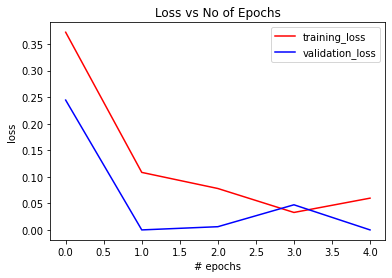

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',label='training_loss')
plt.plot(history.history['val_loss'],'b',label='validation_loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.title ('Loss vs No of Epochs')
plt.legend()
plt.show()

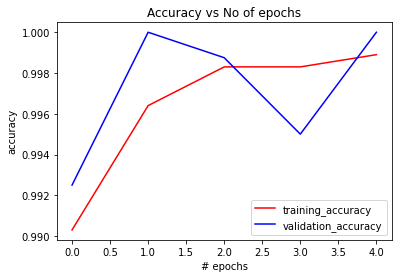

In [18]:
plt.plot(history.history['accuracy'],'r',label='training_accuracy')
plt.plot(history.history['val_accuracy'],'b',label='validation_accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epochs')
plt.legend()
plt.show()

In [19]:
test_datagen = ImageDataGenerator(1./255)
test_set = test_datagen.flow_from_directory(test_path, target_size = (IMG_SIZE, IMG_SIZE), batch_size = 32)
predict = model.predict_generator(test_set)
print(model.evaluate_generator(test_set))

Found 992 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.45353859663009644, 0.9959677457809448]


In [21]:
model.save('mask_detector.model')

INFO:tensorflow:Assets written to: mask_detector.model/assets
